In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir
from matplotlib.image import imread
import cv2

from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import train_test_split
from skimage.transform import resize


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers

### Fonctions

In [2]:
def affichage_image(index):
    print(df_image["Categories"][index])
    plt.imshow(imread(df_image["Liens"][index])) 
    
    
def affichage_matrice(index):
    return imread(df_image["Liens"][index])


def detect_features(model, index) :

    img = imread(df_image["Liens"][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(800,800))
    
    global kp,des, img2
    kp, des = model.detectAndCompute(img, None)
    
    img2 = cv2.drawKeypoints(img, kp, None, flags = 0)
    
    
def matching (index_1, index_2) :
    
    global img_match, matches, good

    model = cv2.ORB_create()

    im1 = imread(df_image["Liens"][index_1])
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im1 = cv2.resize(im1,(800,800))
    
    im2 = imread(df_image["Liens"][index_2])
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    im2 = cv2.resize(im2,(800,800))

    kp1, des1 = model.detectAndCompute(im1, None)
    kp2, des2 = model.detectAndCompute(im2, None) 
    
    # Match descriptors
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    
    good = []
    
    for m,n in matches : 
        if m.distance < 0.75*n.distance:
            good.append([m])
    
    img_match = cv2.drawMatchesKnn(im1, kp1, im2, kp2, good, None)
    img_match = cv2.resize(img_match,(800,800))
    

def plot_km(data, k):
    
    fig = plt.figure(figsize=(15,8))

    cls = cluster.KMeans(n_clusters=1)
    cls.fit(data)
    
    
    ax = fig.add_subplot(121) # Figure cote à cote 1
    plt.title('Répartition des données avant le KMeans')
    ax_1  = sns.scatterplot(x = data[:,0], y = data[:,1], hue = cls.labels_)

    cls = cluster.KMeans(n_clusters=k)
    cls.fit(data)
    
    global label
    label = cls.labels_
    
    ax = fig.add_subplot(122) # Figure cote à cote 2
    plt.title('Répartition des données après le KMeans en {}'.format(k))
    ax_2  = sns.scatterplot(x = data[:,0], y = data[:,1], hue = cls.labels_)
        
    
    return ax_2

def KM_image(index,k):
    
    im = imread(df_image["Liens"][index])/255
    X = im.reshape(-1,3)
    
    km = KMeans(n_clusters = k)
    km.fit(X)
    
    img_seg = km.cluster_centers_
    img_seg = img_seg[km.labels_]
    
    img_seg = img_seg.reshape(im.shape)

    return plt.imshow(img_seg)

def pad_to_size(array, x_shape, y_shape):
    """
    Fonction complétant une matrice par des 0 pour atteindre
    une forme donnée
    
    ---
    Paramètres :
    array : matrice à compléter
    x_shape : int, forme à obtenir, axe 0
    y_shape : int, forme à obtenir, axe 1
    
    """   
    output = np.zeros((x_shape, y_shape))
    if array is None:
        return(output)
    output[:array.shape[0],:array.shape[1]] = array
    
    return output


def predict_image(path):
    
    # Get new image
    img = imread(path)
    
    # Resize image
    rez_img = resize(img,(200,200,3))
    
    plt.imshow(rez_img)
    
    # Predict category
    predictions = model.predict_generator(np.array([rez_img]))
    
    lab_name = ["Baby Care","Beauty and Personal Care","Computers", "Home Decor & Festive Needs","Home Furnishing",
            "Kitchen & Dining","Watches"]
    list_index = [0,1,2,3,4,5,6]
    x = predictions

    for i in range(7):
        for j in range(7):
            if x[0][list_index[i]] > x[0][list_index[j]]:
                temp = list_index[i]
                list_index[i] = list_index[j]
                list_index[j] = temp

    print("Les 5 premières catégories prédites pour cette image sont :\n")

    for i in range(5):
        print(lab_name[list_index[i]])

### Import Dataset

In [3]:
df = pd.read_csv(r"D:\OC\Projet_6\Projet_data.csv")

In [4]:
df

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,...,product_rating,overall_rating,brand,product_specifications,Description_clean,polarity,Word_count,Label_Category_Original,Label_Description_KMeans_Tfid,Label_Description_KMeans_Doc2Vec
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,CRNEG7BKMFFYHQ8Z,1899.000000,899.000000,55b85ea15a1536d46b7190ad6fff8ce7.jpg,...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key feature elegance polyester multicolor abst...,0.350976,159,4,6,1
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,Baby Care,BTWEGFZHGBXPHZUH,600.000000,449.000000,7b72c92c2f6c40268628ec5f14c6d590.jpg,...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specification sathiyas cotton bath towel 3 bat...,0.118750,68,0,6,2
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,Baby Care,BTWEG6SHXTDB2A2Y,2186.197331,1584.527169,64d5d4a258243731dc7bbb1eef49ad74.jpg,...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",key feature eurospa cotton terry face towel se...,0.080357,167,0,6,2
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,BDSEJT9UQWHDUBH4,2699.000000,1299.000000,d4684dcdc759dd9cdf41504698d737d8.jpg,...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key feature santosh royal fashion cotton print...,0.045000,129,4,6,0
4,4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,BDSEJTHNGWVGWWQU,2599.000000,698.000000,6325b6870c54cd47be6ebfbffa620ec7.jpg,...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",key feature jaipur print cotton floral king si...,0.117647,175,4,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,Baby Care,STIE88ZGTX65GH4V,1399.000000,999.000000,958f54f4c46b53c8a0a9b8167d9140bc.jpg,...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",oren empower extra large self adhesive sticker...,0.067394,242,0,6,6
1046,1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,Baby Care,STIEC889ZD5GDCVQ,4930.000000,1896.000000,fd6cbcc22efb6b761bd564c28928483c.jpg,...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",wallmantra large vinyl sticker sticker pack 1 ...,0.412605,154,0,6,1
1047,1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,STIE5UVGW2JWVWCT,4500.000000,1449.000000,5912e037d12774bb73a2048f35a00009.jpg,...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...",buy uberlyfe extra large pigmented polyvinyl f...,0.318367,31,0,2,4
1048,1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Stick

### Préparation Dataset Image

In [5]:
path = "D:\OC\Projet_6\Images"
lien = []

for elt in df["uniq_id"]:
    lien.append(path+"\\"+elt+".jpg")

In [6]:
df_image = pd.DataFrame()

In [7]:
df_image["Liens"] = lien
df_image["Categories"] = df["product_category_tree"]
df_image["Labels"] = df["Label_Category_Original"]
df_image["Categories"] = df["product_category_tree"].apply(lambda x: x.strip(r'[]"').split(' >> ')[0])


In [8]:
df_image.head(3)

,Liens,Categories,Labels
0,D:\OC\Projet_6\Images\55b85ea15a1536d46b7190ad...,Home Furnishing,4
1,D:\OC\Projet_6\Images\7b72c92c2f6c40268628ec5f...,Baby Care,0
2,D:\OC\Projet_6\Images\64d5d4a258243731dc7bbb1e...,Baby Care,0


### Pré Analyse Image

In [9]:
df_image["Categories"].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

Home Furnishing


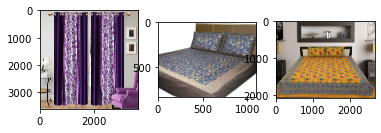

-------
Baby Care


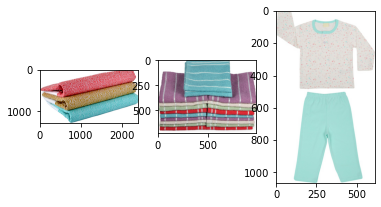

-------
Watches


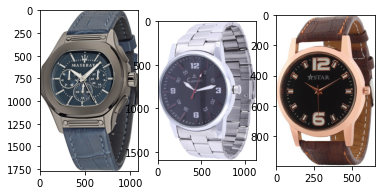

-------
Home Decor & Festive Needs


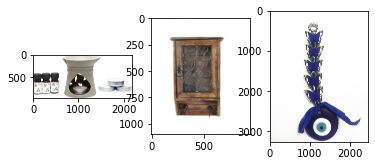

-------
Kitchen & Dining


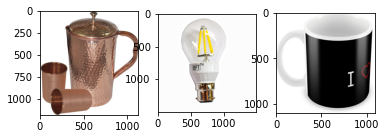

-------
Beauty and Personal Care


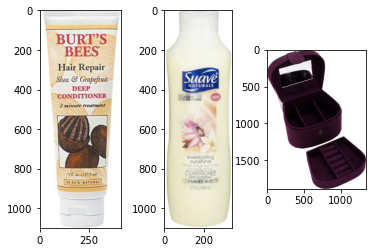

-------
Computers


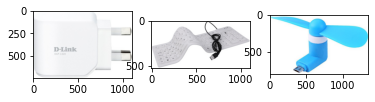

-------


In [10]:
for cat in df_image["Categories"].unique() :
    print(cat)
    
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = df_image[df_image["Categories"]==cat]["Liens"].iloc[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()
    
    print("-------")

Home Furnishing


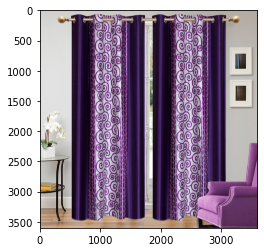

In [11]:
affichage_image(0)

In [12]:
affichage_matrice(0)

array([[[192, 184, 173],
        [192, 184, 173],
        [193, 185, 174],
        ...,
        [174, 165, 156],
        [174, 165, 156],
        [174, 165, 156]],

       [[192, 184, 173],
        [193, 185, 174],
        [193, 185, 174],
        ...,
        [174, 165, 156],
        [174, 165, 156],
        [174, 165, 156]],

       [[192, 186, 174],
        [193, 187, 175],
        [193, 187, 175],
        ...,
        [175, 166, 157],
        [174, 165, 156],
        [174, 165, 156]],

       ...,

       [[209, 174, 136],
        [209, 174, 136],
        [209, 174, 136],
        ...,
        [130,  94,  96],
        [134,  99,  95],
        [139, 104,  98]],

       [[210, 175, 137],
        [210, 175, 137],
        [210, 175, 137],
        ...,
        [140, 105, 101],
        [143, 109, 100],
        [147, 113, 103]],

       [[210, 175, 137],
        [210, 175, 137],
        [210, 175, 137],
        ...,
        [149, 114, 108],
        [151, 117, 107],
        [154, 120, 108]]

In [13]:
affichage_matrice(0).shape

(3600, 3600, 3)

In [14]:
affichage_matrice(1).shape

(1293, 2388, 3)

### Detection de Features

In [15]:
sift = cv2.SIFT_create(1000)
orb = cv2.ORB_create(50)

### SIFT Detection

In [16]:
detect_features(sift, 0)

kp_sift = kp
des_sift = des
img_sift = img2

### ORB (ORIENTED FAST AND ROTATED BRIEF)

In [17]:
detect_features(orb, 0)

kp_orb = kp
des_orb = des
img_orb = img2

### Comparaison détection SIFT ET ORB

In [18]:
print(des_orb.shape,"\n")
print(des_orb)

(50, 32) 

[[ 50 223 106 ... 142 120 141]
 [  3 223  75 ... 139  49 189]
 [ 47  38 192 ...  79  90 132]
 ...
 [222 255 103 ... 247 230 255]
 [158 255  99 ... 247 230 247]
 [222 255 190 ... 247 167 127]]


In [19]:
print(des_sift.shape,"\n")
print(des_sift)

(1001, 128) 

[[  1.   4.  43. ...  12.  51.   6.]
 [ 19.   0.   0. ...   8.  27.   4.]
 [ 54.  99.   4. ...   0.   0.  51.]
 ...
 [  7.   0.   0. ...   0.   5.  75.]
 [  4.   4.   1. ...   2.   0.   6.]
 [  2.   3. 114. ...   4.  17.  94.]]


Text(0.5, 1.0, 'Image Sift')

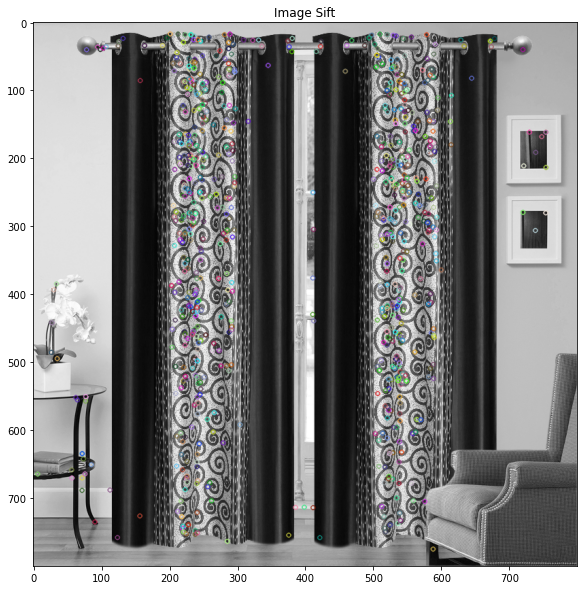

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(img_sift)
plt.title("Image Sift")

Text(0.5, 1.0, 'Image ORB')

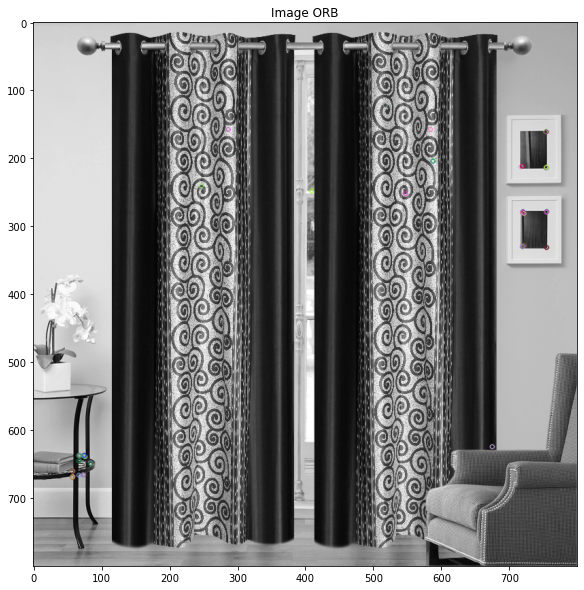

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(img_orb)
plt.title("Image ORB")

### Matching sur deux images

Number of good matches : 500


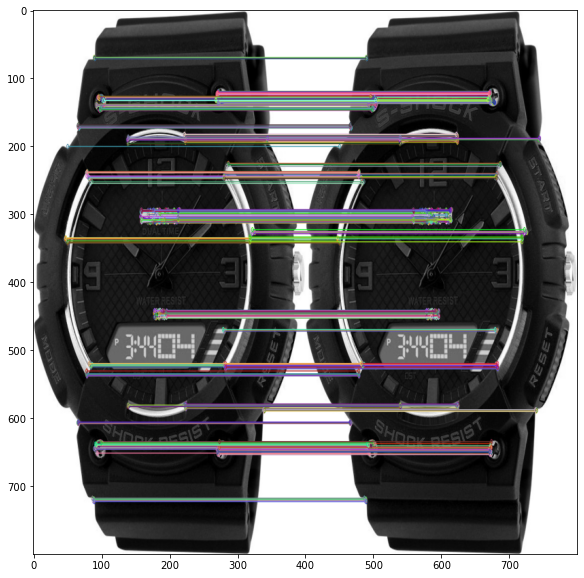

In [22]:
matching(20,20)
print("Number of good matches :",len(good))

plt.figure(figsize=(10,10))
plt.imshow(img_match)

Number of good matches : 1


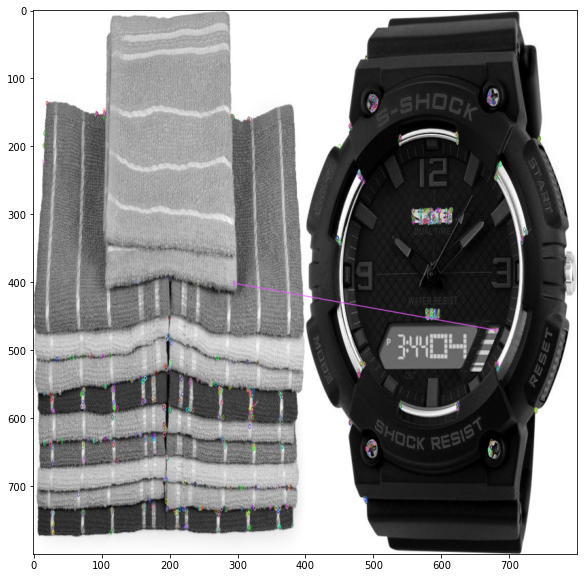

In [23]:
matching(2,20)
print("Number of good matches :",len(good))

plt.figure(figsize=(10,10))
plt.imshow(img_match)

Number of good matches : 4


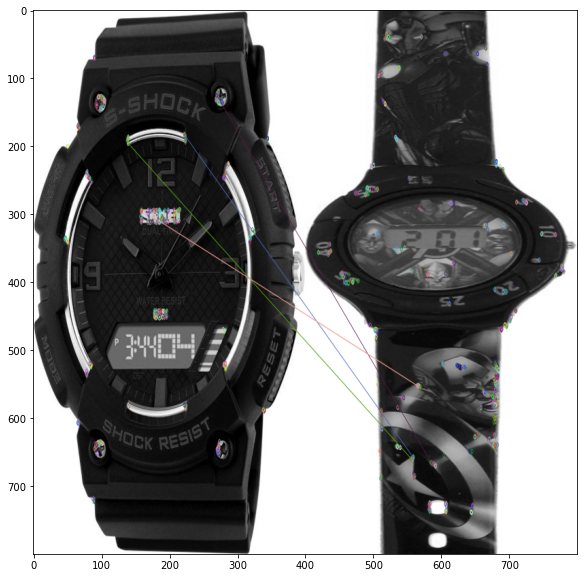

In [24]:
matching(20,30)
print("Number of good matches :",len(good))

plt.figure(figsize=(10,10))
plt.imshow(img_match)

### Applications du KMeans

In [25]:
df_image

,Liens,Categories,Labels
0,D:\OC\Projet_6\Images\55b85ea15a1536d46b7190ad...,Home Furnishing,4
1,D:\OC\Projet_6\Images\7b72c92c2f6c40268628ec5f...,Baby Care,0
2,D:\OC\Projet_6\Images\64d5d4a258243731dc7bbb1e...,Baby Care,0
3,D:\OC\Projet_6\Images\d4684dcdc759dd9cdf415046...,Home Furnishing,4
4,D:\OC\Projet_6\Images\6325b6870c54cd47be6ebfbf...,Home Furnishing,4
...,...,...,...
1045,D:\OC\Projet_6\Images\958f54f4c46b53c8a0a9b816...,Baby Care,0
1046,D:\OC\Projet_6\Images\fd6cbcc22efb6b761bd564c2...,Baby Care,0
1047,D:\OC\Projet_6\Images\5912e037d12774bb73a2048f...,Baby Care,0
1048,D:\OC\Projet_6\Images\c3edc504d1b4f0ba6224fa53...,Baby Care,0


### Segmentation des couleurs d'une image via le KMeans

Home Furnishing


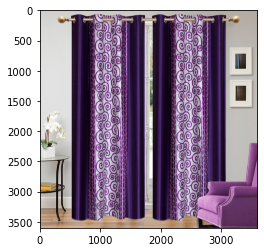

In [26]:
affichage_image(0)

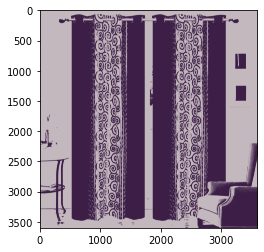

In [27]:
KM_image(0,2)

### Récupération des descripteurs en vue d'un clustering

In [28]:
des_list = []

for elt in df_image["Liens"]:
    img = imread(elt)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(800,800))
    
    kp, des = orb.detectAndCompute(img, None)
    des_list.append(des)
df_image["Des_orb_800_800"] = des_list

    
des_list = []

for elt in df_image["Liens"]:
    img = imread(elt)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(800,800))
    
    kp, des = sift.detectAndCompute(img, None)
    des_list.append(des)
df_image["Des_sift_800_800"] = des_list



C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [29]:
df_image.head()

,Liens,Categories,Labels,Des_orb_800_800,Des_sift_800_800
0,D:\OC\Projet_6\Images\55b85ea15a1536d46b7190ad...,Home Furnishing,4,"[[50, 223, 106, 222, 118, 147, 250, 247, 215, ...","[[1.0, 4.0, 43.0, 125.0, 14.0, 0.0, 0.0, 0.0, ..."
1,D:\OC\Projet_6\Images\7b72c92c2f6c40268628ec5f...,Baby Care,0,"[[72, 230, 188, 50, 185, 153, 81, 175, 251, 61...","[[0.0, 0.0, 0.0, 16.0, 36.0, 4.0, 0.0, 0.0, 73..."
2,D:\OC\Projet_6\Images\64d5d4a258243731dc7bbb1e...,Baby Care,0,"[[43, 176, 180, 211, 253, 253, 249, 95, 159, 1...","[[0.0, 1.0, 2.0, 1.0, 8.0, 90.0, 135.0, 5.0, 6..."
3,D:\OC\Projet_6\Images\d4684dcdc759dd9cdf415046...,Home Furnishing,4,"[[3, 148, 226, 155, 95, 149, 186, 232, 31, 75,...","[[27.0, 9.0, 13.0, 8.0, 2.0, 1.0, 0.0, 29.0, 7..."
4,D:\OC\Projet_6\Images\6325b6870c54cd47be6ebfbf...,Home Furnishing,4,"[[83, 238, 16, 56, 31, 157, 148, 231, 255, 152...","[[25.0, 9.0, 8.0, 3.0, 3.0, 44.0, 42.0, 16.0, ..."


### Suppression des lignes avec des descripteurs Null

In [30]:
df_image[df_image["Des_orb_800_800"].isnull() | df_image["Des_sift_800_800"].isnull() ]

,Liens,Categories,Labels,Des_orb_800_800,Des_sift_800_800
343,D:\OC\Projet_6\Images\9743e6d1c9f3180483825fe4...,Computers,2,None,None
354,D:\OC\Projet_6\Images\c8e2c85eccdc9db55eeb2231...,Computers,2,None,"[[0.0, 0.0, 0.0, 3.0, 106.0, 0.0, 0.0, 0.0, 51..."


Computers


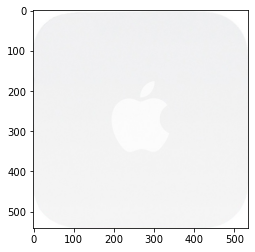

In [31]:
affichage_image(343)

Computers


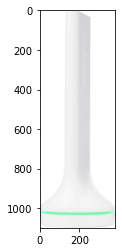

In [32]:
affichage_image(354)

In [33]:
df_image = (df_image[df_image["Des_orb_800_800"].notnull() & df_image["Des_sift_800_800"].notnull()]).reset_index(drop=True)

In [34]:
df_image

,Liens,Categories,Labels,Des_orb_800_800,Des_sift_800_800
0,D:\OC\Projet_6\Images\55b85ea15a1536d46b7190ad...,Home Furnishing,4,"[[50, 223, 106, 222, 118, 147, 250, 247, 215, ...","[[1.0, 4.0, 43.0, 125.0, 14.0, 0.0, 0.0, 0.0, ..."
1,D:\OC\Projet_6\Images\7b72c92c2f6c40268628ec5f...,Baby Care,0,"[[72, 230, 188, 50, 185, 153, 81, 175, 251, 61...","[[0.0, 0.0, 0.0, 16.0, 36.0, 4.0, 0.0, 0.0, 73..."
2,D:\OC\Projet_6\Images\64d5d4a258243731dc7bbb1e...,Baby Care,0,"[[43, 176, 180, 211, 253, 253, 249, 95, 159, 1...","[[0.0, 1.0, 2.0, 1.0, 8.0, 90.0, 135.0, 5.0, 6..."
3,D:\OC\Projet_6\Images\d4684dcdc759dd9cdf415046...,Home Furnishing,4,"[[3, 148, 226, 155, 95, 149, 186, 232, 31, 75,...","[[27.0, 9.0, 13.0, 8.0, 2.0, 1.0, 0.0, 29.0, 7..."
4,D:\OC\Projet_6\Images\6325b6870c54cd47be6ebfbf...,Home Furnishing,4,"[[83, 238, 16, 56, 31, 157, 148, 231, 255, 152...","[[25.0, 9.0, 8.0, 3.0, 3.0, 44.0, 42.0, 16.0, ..."
...,...,...,...,...,...
1043,D:\OC\Projet_6\Images\958f54f4c46b53c8a0a9b816...,Baby Care,0,"[[138, 205, 18, 222, 181, 129, 190, 231, 156, ...","[[0.0, 0.0, 7.0, 152.0, 44.0, 0.0, 0.0, 0.0, 4..."
1044,D:\OC\Projet_6\Images\fd6cbcc22efb6b761bd564c2...,Baby Care,0,"[[84, 176, 223, 229, 174, 14, 121, 208, 42, 17...","[[0.0, 0.0, 0.0, 0.0, 56.0, 30.0, 1.0, 0.0, 59..."
1045,D:\OC\Projet_6\Images\5912e037d12774bb73a2048f...,Baby Care,0,"[[89, 184, 156, 163, 43, 156, 48, 144, 234, 53...","[[1.0, 15.0, 1.0, 1.0, 115.0, 65.0, 1.0, 1.0, ..."
1046,D:\OC\Projet_6\Images\c3edc504d1b4f0ba6224fa53...,Baby Care,0,"[[35, 13, 99, 137, 214, 178, 254, 71, 89, 65, ...","[[63.0, 8.0, 0.0, 3.0, 18.0, 3.0, 0.0, 1.0, 13..."


### ORB

### Nous allons donner la même forme à toutes les matrices de description ORB

In [35]:
max_x = 0
max_y = 0
for index, row in df_image.iterrows():
    desc_x,desc_y = row["Des_orb_800_800"].shape
    if desc_x > max_x:
        max_x = desc_x
    if desc_y > max_y:
        max_y = desc_y
print("max_x : {}".format(max_x))
print("max_y : {}".format(max_y))

max_x : 50
max_y : 32


In [36]:
df_image["Orb_pad"] =  df_image["Des_orb_800_800"].apply(lambda x:  np.array(pad_to_size(x,max_x,max_y)))

x = df_image["Orb_pad"].to_numpy()

data_orb  = np.array([array2d for array2d in x])

In [37]:
data_orb.shape

(1048, 50, 32)

In [38]:
data_orb = data_orb.reshape(data_orb.shape[0],data_orb.shape[1] * data_orb.shape[2])

In [39]:
data_orb.shape

(1048, 1600)

In [40]:
data_orb

array([[ 50., 223., 106., ..., 247., 167., 127.],
       [ 72., 230., 188., ..., 202., 177., 169.],
       [ 43., 176., 180., ..., 132.,  71.,  59.],
       ...,
       [ 89., 184., 156., ..., 168.,  82., 164.],
       [ 35.,  13.,  99., ...,  82., 166., 147.],
       [ 23., 212., 237., ...,   3., 105., 172.]])

In [41]:
df_image["Des_orb_800_800"]

0       [[50, 223, 106, 222, 118, 147, 250, 247, 215, ...
1       [[72, 230, 188, 50, 185, 153, 81, 175, 251, 61...
2       [[43, 176, 180, 211, 253, 253, 249, 95, 159, 1...
3       [[3, 148, 226, 155, 95, 149, 186, 232, 31, 75,...
4       [[83, 238, 16, 56, 31, 157, 148, 231, 255, 152...
                              ...                        
1043    [[138, 205, 18, 222, 181, 129, 190, 231, 156, ...
1044    [[84, 176, 223, 229, 174, 14, 121, 208, 42, 17...
1045    [[89, 184, 156, 163, 43, 156, 48, 144, 234, 53...
1046    [[35, 13, 99, 137, 214, 178, 254, 71, 89, 65, ...
1047    [[23, 212, 237, 57, 138, 102, 189, 205, 132, 8...
Name: Des_orb_800_800, Length: 1048, dtype: object

### Clustering KMeans

In [42]:
cls = cluster.KMeans(n_clusters=7)

cls.fit(data_orb)
lab_orb = cls.labels_
df_image["Label_Orb"] = lab_orb

In [43]:
df_image.head()

,Liens,Categories,Labels,Des_orb_800_800,Des_sift_800_800,Orb_pad,Label_Orb
0,D:\OC\Projet_6\Images\55b85ea15a1536d46b7190ad...,Home Furnishing,4,"[[50, 223, 106, 222, 118, 147, 250, 247, 215, ...","[[1.0, 4.0, 43.0, 125.0, 14.0, 0.0, 0.0, 0.0, ...","[[50.0, 223.0, 106.0, 222.0, 118.0, 147.0, 250...",2
1,D:\OC\Projet_6\Images\7b72c92c2f6c40268628ec5f...,Baby Care,0,"[[72, 230, 188, 50, 185, 153, 81, 175, 251, 61...","[[0.0, 0.0, 0.0, 16.0, 36.0, 4.0, 0.0, 0.0, 73...","[[72.0, 230.0, 188.0, 50.0, 185.0, 153.0, 81.0...",5
2,D:\OC\Projet_6\Images\64d5d4a258243731dc7bbb1e...,Baby Care,0,"[[43, 176, 180, 211, 253, 253, 249, 95, 159, 1...","[[0.0, 1.0, 2.0, 1.0, 8.0, 90.0, 135.0, 5.0, 6...","[[43.0, 176.0, 180.0, 211.0, 253.0, 253.0, 249...",1
3,D:\OC\Projet_6\Images\d4684dcdc759dd9cdf415046...,Home Furnishing,4,"[[3, 148, 226, 155, 95, 149, 186, 232, 31, 75,...","[[27.0, 9.0, 13.0, 8.0, 2.0, 1.0, 0.0, 29.0, 7...","[[3.0, 148.0, 226.0, 155.0, 95.0, 149.0, 186.0...",5
4,D:\OC\Projet_6\Images\6325b6870c54cd47be6ebfbf...,Home Furnishing,4,"[[83, 238, 16, 56, 31, 157, 148, 231, 255, 152...","[[25.0, 9.0, 8.0, 3.0, 3.0, 44.0, 42.0, 16.0, ...","[[83.0, 238.0, 16.0, 56.0, 31.0, 157.0, 148.0,...",5


### Affichage après réduction de dimensions via T-SNE

In [44]:
data_orb.shape

(1048, 1600)

In [45]:
tsne = TSNE(n_components=2)
orb_tsne = tsne.fit_transform(data_orb)
orb_tsne.shape

(1048, 2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


<AxesSubplot:title={'center':'Répartition des données après le KMeans en 7'}>

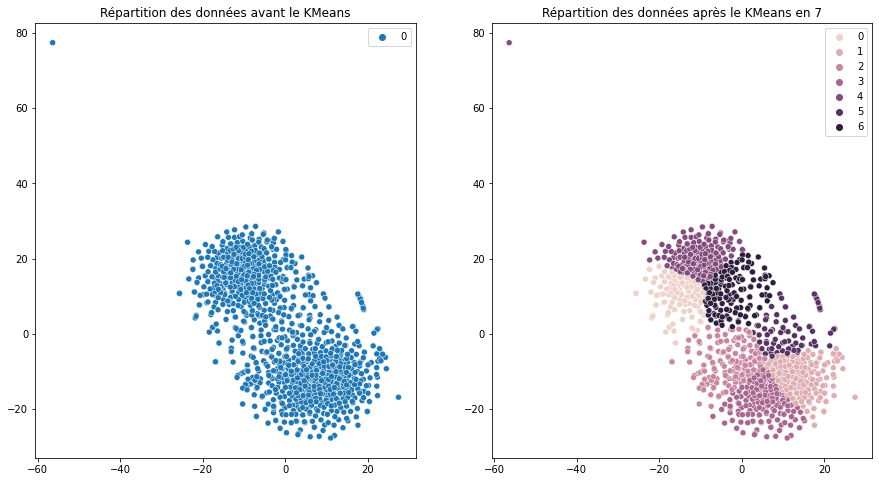

In [46]:
plot_km(orb_tsne,7)

### SIFT

### Nous allons donner la même forme à toutes les matrices de description SIFT

In [47]:
max_x = 0
max_y = 0
for index, row in df_image.iterrows():
    desc_x,desc_y = row["Des_sift_800_800"].shape
    if desc_x > max_x:
        max_x = desc_x
    if desc_y > max_y:
        max_y = desc_y
print("max_x : {}".format(max_x))
print("max_y : {}".format(max_y))

max_x : 1002
max_y : 128


In [48]:
df_image["Sift_pad"] =  df_image["Des_sift_800_800"].apply(lambda x:  np.array(pad_to_size(x,max_x,max_y)))

x = df_image["Sift_pad"].to_numpy()

data_sift  = np.array([array2d for array2d in x])

In [49]:
data_sift.shape

(1048, 1002, 128)

In [50]:
data_sift = data_sift.reshape(data_sift.shape[0],data_sift.shape[1] * data_sift.shape[2])

In [51]:
data_sift.shape

(1048, 128256)

In [52]:
data_sift

array([[ 1.,  4., 43., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 1., 15.,  1., ...,  0.,  0.,  0.],
       [63.,  8.,  0., ...,  0.,  0.,  0.],
       [37.,  7.,  2., ...,  0.,  0.,  0.]])

In [53]:
df_image["Des_sift_800_800"]

0       [[1.0, 4.0, 43.0, 125.0, 14.0, 0.0, 0.0, 0.0, ...
1       [[0.0, 0.0, 0.0, 16.0, 36.0, 4.0, 0.0, 0.0, 73...
2       [[0.0, 1.0, 2.0, 1.0, 8.0, 90.0, 135.0, 5.0, 6...
3       [[27.0, 9.0, 13.0, 8.0, 2.0, 1.0, 0.0, 29.0, 7...
4       [[25.0, 9.0, 8.0, 3.0, 3.0, 44.0, 42.0, 16.0, ...
                              ...                        
1043    [[0.0, 0.0, 7.0, 152.0, 44.0, 0.0, 0.0, 0.0, 4...
1044    [[0.0, 0.0, 0.0, 0.0, 56.0, 30.0, 1.0, 0.0, 59...
1045    [[1.0, 15.0, 1.0, 1.0, 115.0, 65.0, 1.0, 1.0, ...
1046    [[63.0, 8.0, 0.0, 3.0, 18.0, 3.0, 0.0, 1.0, 13...
1047    [[37.0, 7.0, 2.0, 135.0, 127.0, 0.0, 0.0, 11.0...
Name: Des_sift_800_800, Length: 1048, dtype: object

### Clustering KMeans

In [54]:
cls = cluster.KMeans(n_clusters=7)

cls.fit(data_sift)
lab_sift = cls.labels_
df_image["Label_Sift"] = lab_sift

In [55]:
df_image.head()

,Liens,Categories,Labels,Des_orb_800_800,Des_sift_800_800,Orb_pad,Label_Orb,Sift_pad,Label_Sift
0,D:\OC\Projet_6\Images\55b85ea15a1536d46b7190ad...,Home Furnishing,4,"[[50, 223, 106, 222, 118, 147, 250, 247, 215, ...","[[1.0, 4.0, 43.0, 125.0, 14.0, 0.0, 0.0, 0.0, ...","[[50.0, 223.0, 106.0, 222.0, 118.0, 147.0, 250...",2,"[[1.0, 4.0, 43.0, 125.0, 14.0, 0.0, 0.0, 0.0, ...",2
1,D:\OC\Projet_6\Images\7b72c92c2f6c40268628ec5f...,Baby Care,0,"[[72, 230, 188, 50, 185, 153, 81, 175, 251, 61...","[[0.0, 0.0, 0.0, 16.0, 36.0, 4.0, 0.0, 0.0, 73...","[[72.0, 230.0, 188.0, 50.0, 185.0, 153.0, 81.0...",5,"[[0.0, 0.0, 0.0, 16.0, 36.0, 4.0, 0.0, 0.0, 73...",4
2,D:\OC\Projet_6\Images\64d5d4a258243731dc7bbb1e...,Baby Care,0,"[[43, 176, 180, 211, 253, 253, 249, 95, 159, 1...","[[0.0, 1.0, 2.0, 1.0, 8.0, 90.0, 135.0, 5.0, 6...","[[43.0, 176.0, 180.0, 211.0, 253.0, 253.0, 249...",1,"[[0.0, 1.0, 2.0, 1.0, 8.0, 90.0, 135.0, 5.0, 6...",4
3,D:\OC\Projet_6\Images\d4684dcdc759dd9cdf415046...,Home Furnishing,4,"[[3, 148, 226, 155, 95, 149, 186, 232, 31, 75,...","[[27.0, 9.0, 13.0, 8.0, 2.0, 1.0, 0.0, 29.0, 7...","[[3.0, 148.0, 226.0, 155.0, 95.0, 149.0, 186.0...",5,"[[27.0, 9.0, 13.0, 8.0, 2.0, 1.0, 0.0, 29.0, 7...",2
4,D:\OC\Projet_6\Images\6325b6870c54cd47be6ebfbf...,Home Furnishing,4,"[[83, 238, 16, 56, 31, 157, 148, 231, 255, 152...","[[25.0, 9.0, 8.0, 3.0, 3.0, 44.0, 42.0, 16.0, ...","[[83.0, 238.0, 16.0, 56.0, 31.0, 157.0, 148.0,...",5,"[[25.0, 9.0, 8.0, 3.0, 3.0, 44.0, 42.0, 16.0, ...",6


### Affichage après réduction de dimensions via T-SNE

In [56]:
data_sift.shape

(1048, 128256)

In [57]:
tsne = TSNE(n_components=2)
sift_tsne = tsne.fit_transform(data_sift)
sift_tsne.shape

(1048, 2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


<AxesSubplot:title={'center':'Répartition des données après le KMeans en 7'}>

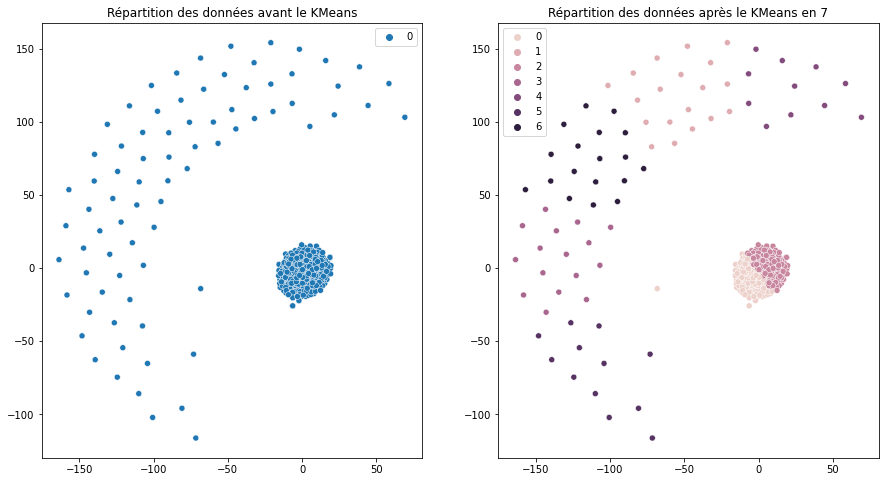

In [58]:
plot_km(sift_tsne,7)

### Comparaisons entre les labels obtenus

### Score de ARI

In [59]:
adjusted_rand_score(df_image["Labels"], df_image["Label_Orb"])

0.018184014892714553

In [60]:
adjusted_rand_score(df_image["Labels"], df_image["Label_Sift"])

0.054089541337084254

In [61]:
adjusted_rand_score(df_image["Label_Sift"], df_image["Label_Orb"])

0.06683680760118897

### Crosstab Labels

In [62]:
pd.crosstab(df_image["Categories"], df_image["Labels"], margins=True)

Labels,0,1,2,3,4,5,6,All
Categories,,,,,,,,
Baby Care,150,0,0,0,0,0,0,150
Beauty and Personal Care,0,150,0,0,0,0,0,150
Computers,0,0,148,0,0,0,0,148
Home Decor & Festive Needs,0,0,0,150,0,0,0,150
Home Furnishing,0,0,0,0,150,0,0,150
Kitchen & Dining,0,0,0,0,0,150,0,150
Watches,0,0,0,0,0,0,150,150
All,150,150,148,150,150,150,150,1048


In [63]:
pd.crosstab(df_image["Categories"], df_image["Label_Orb"], margins=True)

Label_Orb,0,1,2,3,4,5,6,All
Categories,,,,,,,,
Baby Care,0,51,36,20,1,31,11,150
Beauty and Personal Care,0,34,16,54,0,34,12,150
Computers,7,36,15,52,9,16,13,148
Home Decor & Festive Needs,0,22,19,55,0,45,9,150
Home Furnishing,0,29,39,24,4,46,8,150
Kitchen & Dining,0,46,25,26,0,36,17,150
Watches,0,49,30,44,0,20,7,150
All,7,267,180,275,14,228,77,1048


In [64]:
pd.crosstab(df_image["Categories"], df_image["Label_Sift"], margins=True)

Label_Sift,0,1,2,3,4,5,6,All
Categories,,,,,,,,
Baby Care,20,16,19,17,51,5,22,150
Beauty and Personal Care,17,14,61,9,46,1,2,150
Computers,22,11,21,79,12,0,3,148
Home Decor & Festive Needs,9,10,70,8,50,2,1,150
Home Furnishing,8,6,44,10,56,12,14,150
Kitchen & Dining,21,20,25,44,34,4,2,150
Watches,25,14,30,13,64,0,4,150
All,122,91,270,180,313,24,48,1048


### Transfer Learning - Classification

### Récupération des jeux de test et train

In [65]:
tf_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(1/255,validation_split=0.2)

X_train = tf_data_gen.flow_from_dataframe(dataframe = df_image, x_col='Liens', y_col='Categories', target_size=(200,200),
                                          batch_size= 8, class_mode='categorical',subset='training')
X_test  = tf_data_gen.flow_from_dataframe(dataframe = df_image, x_col='Liens', y_col='Categories', target_size=(200,200),
                                          batch_size= 8, class_mode='categorical',subset='validation')

Found 839 validated image filenames belonging to 7 classes.
Found 209 validated image filenames belonging to 7 classes.


### Model Inception V3

In [66]:
Image_size = [200, 200]

inception = InceptionV3(input_shape=Image_size+[3], weights='imagenet',include_top=False)

In [67]:
for layer in inception.layers:
    layer.trainable = False

In [68]:
inception.output

<KerasTensor: shape=(None, 4, 4, 2048) dtype=float32 (created by layer 'mixed10')>

In [69]:
x = Flatten()(inception.output)
prediction = Dense(7,activation ='softmax')(x)

In [70]:
model = Model(inputs = inception.input, outputs = prediction)

In [71]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [72]:
model.compile(loss ='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [73]:
hist = model.fit_generator(generator=X_train,validation_data=X_test, epochs=10, steps_per_epoch  = len(X_train),validation_steps=len(X_test))

C:\Users\anoja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\anoja\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
 13/105 [==>...........................] - ETA: 39s - loss: 347.6805 - accuracy: 0.1635

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


105/105 [==============================] - 63s 571ms/step - loss: 218.2129 - accuracy: 0.2980 - val_loss: 213.4274 - val_accuracy: 0.1818
Epoch 2/10
105/105 [==============================] - 66s 625ms/step - loss: 124.2929 - accuracy: 0.4732 - val_loss: 335.6614 - val_accuracy: 0.2010
Epoch 3/10
105/105 [==============================] - 72s 691ms/step - loss: 111.3518 - accuracy: 0.5530 - val_loss: 630.4595 - val_accuracy: 0.2344
Epoch 4/10
105/105 [==============================] - 61s 585ms/step - loss: 79.4207 - accuracy: 0.6365 - val_loss: 258.1461 - val_accuracy: 0.2632
Epoch 5/10
105/105 [==============================] - 62s 594ms/step - loss: 53.1611 - accuracy: 0.7044 - val_loss: 310.0210 - val_accuracy: 0.2440
Epoch 6/10
105/105 [==============================] - 63s 597ms/step - loss: 57.5901 - accuracy: 0.7020 - val_loss: 638.0815 - val_accuracy: 0.1627
Epoch 7/10
105/105 [==============================] - 74s 704ms/step - loss: 39.1798 - accuracy: 0.7831 - val_loss: 358.

In [74]:
model.evaluate_generator(generator=X_test, steps = len(X_test))[1]

C:\Users\anoja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.19617225229740143

In [75]:
hist.history["accuracy"]

[0.29797378182411194,
 0.47318235039711,
 0.5530393123626709,
 0.6364719867706299,
 0.7044100165367126,
 0.7020262479782104,
 0.7830750942230225,
 0.8128724694252014,
 0.7663885354995728,
 0.792610228061676]

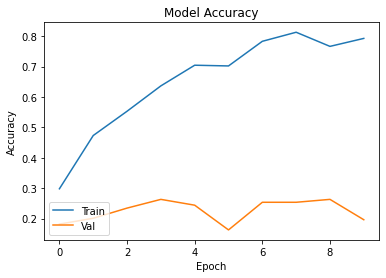

In [76]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc='lower left')

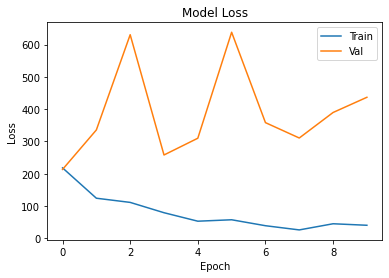

In [77]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc='upper right')

### Test sur les mêmes images

C:\Users\anoja\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Les 5 premières catégories prédites pour cette image sont :

Computers
Home Decor & Festive Needs
Home Furnishing
Baby Care
Beauty and Personal Care


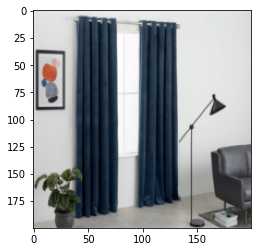

In [78]:
img_path = "D:\OC\Projet_6\Val\\test1.jpg"
predict_image(img_path)

Les 5 premières catégories prédites pour cette image sont :

Computers
Home Furnishing
Baby Care
Home Decor & Festive Needs
Beauty and Personal Care


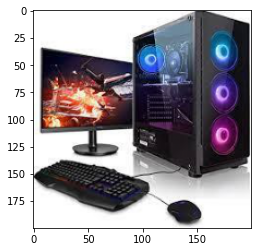

In [79]:
img_path = "D:\OC\Projet_6\Val\\test2.jpg"
predict_image(img_path)

Les 5 premières catégories prédites pour cette image sont :

Computers
Home Decor & Festive Needs
Home Furnishing
Baby Care
Beauty and Personal Care


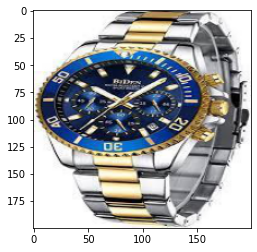

In [80]:
img_path = "D:\OC\Projet_6\Val\\test3.jpg"
predict_image(img_path)